In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Study Whether Housing Prices Are Effected By Recessions

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)


**Definitions:**
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.


# 1. Load Data and Clean Data

For this project, we will use 3 data sources:
1. From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
2. From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.
3. From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.

## 1.1 Get List of University Towns

Create DataFrame of towns and the states they are in from the `university_towns.txt` list.

In [4]:
filename = 'university_towns.txt'
try:
    fhand = open(filename)
except:
    print('{} does not exist!'.format(filename))
    exit()

In [3]:
count = 0
for line in fhand:
    count += 1
    print(line.rstrip())
    if count == 10: break

Alabama[edit]
Auburn (Auburn University)[1]
Florence (University of North Alabama)
Jacksonville (Jacksonville State University)[2]
Livingston (University of West Alabama)[2]
Montevallo (University of Montevallo)[2]
Troy (Troy University)[2]
Tuscaloosa (University of Alabama, Stillman College, Shelton State)[3][4]
Tuskegee (Tuskegee University)[5]
Alaska[edit]


We want to extract the state and rigion name from above dataset. The state names are in the line with `[edit]`, and the following lines contain region names in that state. That is, we can extract region names in front of `(`. 

In [5]:
uni_towns = list()

for line in fhand:
    if 'edit' in line:
        current_state = line.split('[')[0]
    else:
        uni_towns.append([current_state, line.split('(')[0].rstrip()])

In [6]:
uni_towns_df = pd.DataFrame(uni_towns, columns=['State', 'RegionName'])

In [7]:
uni_towns_df.head()

,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo


## 1.2 Get GDP DataFrame and Find Recession Period 

Read the GDP data from `gdplev.xls`. We use the chained value in 2009 dollars, in quarterly intervals, in the file `gdplev.xls`.

In [8]:
gdplev = pd.read_excel("gdplev.xls", skiprows=7)

In [9]:
gdplev.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,1929.0,104.6,1056.6,NaN,1947q1,243.1,1934.5,NaN
1,1930.0,92.2,966.7,NaN,1947q2,246.3,1932.3,NaN
2,1931.0,77.4,904.8,NaN,1947q3,250.1,1930.3,NaN
3,1932.0,59.5,788.2,NaN,1947q4,260.3,1960.7,NaN
4,1933.0,57.2,778.3,NaN,1948q1,266.2,1989.5,NaN


Note that the first three columns are associated with annual gross domestic product. Since we do not use them here, we drop them from the DataFrame. Also, `Unnamed: 3` and `Unnamed: 7` are blank columns in the xls file so we drop them, too. Also, `Unnamed: 5` is GDP in billions of current dollars, and `Unnamed: 6` is GDP in billions of chained 2009 dollars. Since we are interested in GDP in billions of chained 2009 dollars only so we also drop `Unnamed: 5`. In the end, we rename `Unnamed: 4` and `Unnamed: 6` as `quarter` and `gdp`.

In [10]:
gdplev.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2','Unnamed: 3', 'Unnamed: 5', 'Unnamed: 7'], axis=1, inplace=True)
gdplev.head()

,Unnamed: 4,Unnamed: 6
0,1947q1,1934.5
1,1947q2,1932.3
2,1947q3,1930.3
3,1947q4,1960.7
4,1948q1,1989.5


In [11]:
gdplev.rename(index=str, columns={'Unnamed: 4':'quarter', 'Unnamed: 6':'gdp'}, inplace=True)
gdplev.head()

,quarter,gdp
0,1947q1,1934.5
1,1947q2,1932.3
2,1947q3,1930.3
3,1947q4,1960.7
4,1948q1,1989.5


In [12]:
# Find the position of 1999q4
gdplev[gdplev['quarter']=='1999q4']

,quarter,gdp
211,1999q4,12323.3


In [13]:
gdplev = gdplev[212:]

In [14]:
gdplev.reset_index(drop=True, inplace=True)

In [15]:
gdplev.head()

,quarter,gdp
0,2000q1,12359.1
1,2000q2,12592.5
2,2000q3,12607.7
3,2000q4,12679.3
4,2001q1,12643.3


Since we want to study the housing prices of university towns during recessions, we are looking for recessions from GDP data from the first quarter of 2000 onward.

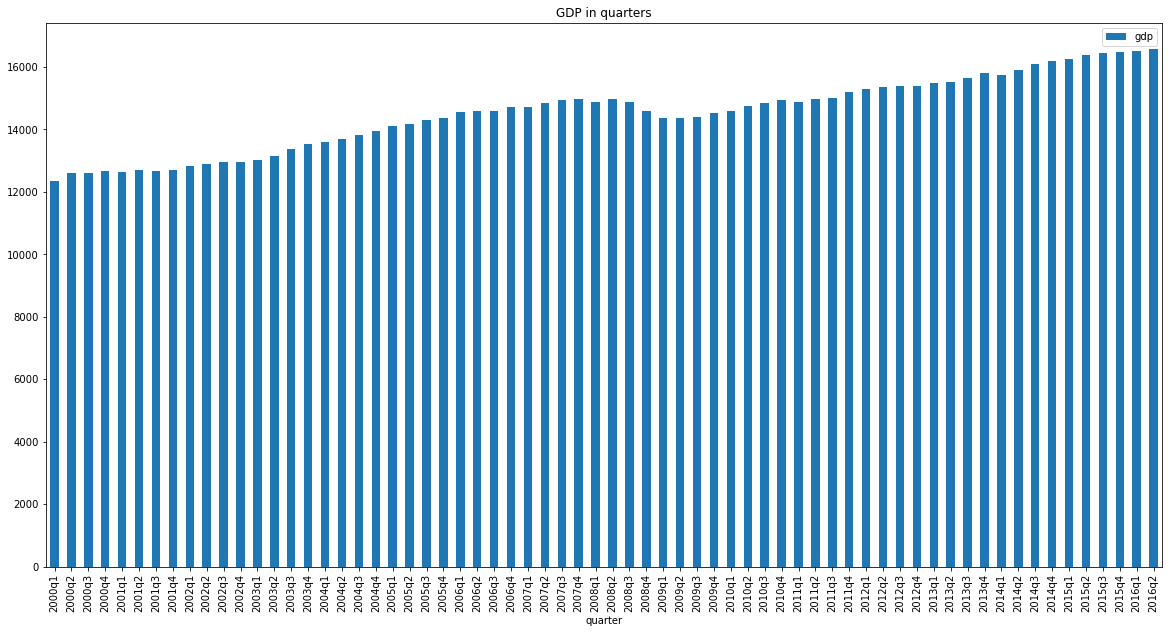

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

ax = gdplev.plot.bar(title='GDP in quarters', figsize=(20, 10),  legend=True, x='quarter', y='gdp')
plt.show()

From above plot, we can see that the year and quarter of the recession start time, end time, and bottom time are `2008q3`, `2009q4`, and `2009q2`, respectively. In what follows, we run programs to confirm our observations.

In [17]:
# Find the year and quarter of the recession start time
found_start = -1

for i in range(2, len(gdplev)):
    if (found_start == -1) and (gdplev.iloc[i-2][1] > gdplev.iloc[i-1][1]) and (gdplev.iloc[i-1][1] > gdplev.iloc[i][1]):
        recession_start = gdplev.iloc[i-1][0]
        found_start = i-1
    

    

In [18]:
recession_start

'2008q3'

In [19]:
# Find the year and quarter of the recession end time
found_end = -1

for i in range(found_start, len(gdplev)):
    if (found_end == -1) and (gdplev.iloc[i-2][1] < gdplev.iloc[i-1][1]) and (gdplev.iloc[i-1][1] < gdplev.iloc[i][1]):
        recession_end =  gdplev.iloc[i][0] 
        found_end = i

In [20]:
recession_end

'2009q4'

In [21]:
# Find the year and quarter of the recession bottom time
recession_bottom = gdplev.iloc[gdplev.iloc[found_start:found_end+1, 1 ].idxmin(), 0]

In [22]:
recession_bottom

'2009q2'

## 1.3 Load Housing Data and Covert it to Quarters

In [23]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [24]:
# Load housing data from `City_Zhvi_AllHomes.csv` from the Zillow research data site
housing = pd.read_csv('City_Zhvi_AllHomes.csv')
housing.head()

,RegionID,RegionName,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,6181,New York,NY,New York,Queens,1,NaN,NaN,NaN,NaN,...,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2,155000.0,154600.0,154400.0,154200.0,...,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
2,17426,Chicago,IL,Chicago,Cook,3,109700.0,109400.0,109300.0,109300.0,...,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
3,13271,Philadelphia,PA,Philadelphia,Philadelphia,4,50000.0,49900.0,49600.0,49400.0,...,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
4,40326,Phoenix,AZ,Phoenix,Maricopa,5,87200.0,87700.0,88200.0,88400.0,...,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900


In [25]:
housing['State'] = housing['State'].map(states)
housing.set_index(['State', 'RegionName'], inplace=True)
housing.head()

,,RegionID,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,6181,New York,Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,...,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
California,Los Angeles,12447,Los Angeles-Long Beach-Anaheim,Los Angeles,2,155000.0,154600.0,154400.0,154200.0,154100.0,154300.0,...,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
Illinois,Chicago,17426,Chicago,Cook,3,109700.0,109400.0,109300.0,109300.0,109100.0,109000.0,...,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
Pennsylvania,Philadelphia,13271,Philadelphia,Philadelphia,4,50000.0,49900.0,49600.0,49400.0,49400.0,49300.0,...,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
Arizona,Phoenix,40326,Phoenix,Maricopa,5,87200.0,87700.0,88200.0,88400.0,88500.0,88900.0,...,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900


In [26]:
# We are interested in time after 2000
housing = housing.loc[:, '2000-01': ]
housing.head()

,,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,...,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
California,Los Angeles,204400.0,207000.0,209800.0,212300.0,214500.0,216600.0,219000.0,221100.0,222800.0,224300.0,...,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
Illinois,Chicago,136800.0,138300.0,140100.0,141900.0,143700.0,145300.0,146700.0,147900.0,149000.0,150400.0,...,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
Pennsylvania,Philadelphia,52700.0,53100.0,53200.0,53400.0,53700.0,53800.0,53800.0,54100.0,54500.0,54700.0,...,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
Arizona,Phoenix,111000.0,111700.0,112800.0,113700.0,114300.0,115100.0,115600.0,115900.0,116500.0,117200.0,...,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900


We covert the time into quarters. A quarter is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.

In [27]:
# Converts the housing data to quarters
old_columns = list(housing.columns.values)

In [28]:
def convert_month_to_quarters(yymm):
    """
    Convert the time in form of yyyy-mm to yyyyq_i where q_i are quarters
    
    Parameters:
    -----------
    yymm: list of strings 
          the time in form of yyyy-mm
          
    Return
    ------
    quarters: dictionary of strings
              the map of time from the form yyyy-mm to yyyyq_i
    """
    quarters = dict()
    
    # Number of data to convert
    n = len(yymm)
    for mon in yymm:
        year, month = mon.split('-')
        
        mm = int(month)
        
        if (mm == 1) or (mm == 2) or (mm == 3):
            month = 'q1'
        elif (mm == 4) or (mm == 5) or (mm == 6):
            month = 'q2'
        elif (mm == 7) or (mm == 8) or (mm == 9):
            month = 'q3'
        else:
            month = 'q4'
        quarters[mon] = year+month
        
    return quarters
        

In [29]:
# Create the map to convert column names from yyyy-mm to yyyyq_i
new_columns = convert_month_to_quarters(old_columns)

In [30]:
housing.rename(index=str, columns=new_columns, inplace=True)

In [31]:
housing.head()

,,2000q1,2000q1,2000q1,2000q2,2000q2,2000q2,2000q3,2000q3,2000q3,2000q4,...,2015q4,2015q4,2016q1,2016q1,2016q1,2016q2,2016q2,2016q2,2016q3,2016q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
California,Los Angeles,204400.0,207000.0,209800.0,212300.0,214500.0,216600.0,219000.0,221100.0,222800.0,224300.0,...,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
Illinois,Chicago,136800.0,138300.0,140100.0,141900.0,143700.0,145300.0,146700.0,147900.0,149000.0,150400.0,...,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
Pennsylvania,Philadelphia,52700.0,53100.0,53200.0,53400.0,53700.0,53800.0,53800.0,54100.0,54500.0,54700.0,...,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
Arizona,Phoenix,111000.0,111700.0,112800.0,113700.0,114300.0,115100.0,115600.0,115900.0,116500.0,117200.0,...,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900


In [32]:
housing = housing.T.groupby(level=0).mean().T

In [33]:
housing.head()

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,...,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
California,Los Angeles,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,...,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
Illinois,Chicago,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,...,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
Pennsylvania,Philadelphia,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,...,113733.333333,115300.000000,115666.666667,116200.000000,117966.666667,121233.333333,122200.000000,123433.333333,126933.333333,128700.0
Arizona,Phoenix,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,126533.333333,128366.666667,...,164266.666667,165366.666667,168500.000000,171533.333333,174166.666667,179066.666667,183833.333333,187900.000000,191433.333333,195200.0


This dataframe above is a dataframe with columns for `2000q1` through `2016q3`, and have a multi-index in the shape of `["State","RegionName"]`. Note that in the last column, `2016q3`, it's the average of two months only, not full quarter, so it may not be reliable to reflect the house pricing in that quarter.

# 2. Hypothesis Testing

We carry out hypothesis testing in the following to test whether university towns have their mean housing prices less effected by recessions. We have already know that the recessions, starting from `2008q3` and ending at `2009q4`.

$H_0$: University towns have their mean housing prices effected by recessions compared to the non-university towns.

$$ \mu_{uni} = \mu_{non} $$

where $\mu$ is the mean of ratio, and ratio is calculated by

$$ \text{ratio} = \frac{price at start time - prie at bottom time}{price at start time} $$

and uni denotes university towns; non denotes non-university towns.

$H_A$: University towns have their mean housing prices **less** effected by recessions compared to the non-university towns.

$$ \mu_{uni} < \mu_{non} $$

We will examine whether the p-value is lower than the threshold $\alpha = 0.01$ or not by applying one-sided hypothesis testing.

### Prepare Data for Hypothesis Testing

In [34]:
# We are only interested in recession period from recession start time to bottom time
housing_data = housing.loc[:, recession_start: recession_bottom]
housing_data.head()

,,2008q3,2008q4,2009q1,2009q2
State,RegionName,,,,
New York,New York,499766.666667,487933.333333,477733.333333,465833.333333
California,Los Angeles,469500.000000,443966.666667,426266.666667,413900.000000
Illinois,Chicago,232000.000000,227033.333333,223766.666667,219700.000000
Pennsylvania,Philadelphia,116933.333333,115866.666667,116200.000000,116166.666667
Arizona,Phoenix,193766.666667,183333.333333,177566.666667,168233.333333


In [35]:
# Reset index in housing_data dataframe.
housing_data.reset_index(inplace=True)
housing_data.head()

,State,RegionName,2008q3,2008q4,2009q1,2009q2
0,New York,New York,499766.666667,487933.333333,477733.333333,465833.333333
1,California,Los Angeles,469500.000000,443966.666667,426266.666667,413900.000000
2,Illinois,Chicago,232000.000000,227033.333333,223766.666667,219700.000000
3,Pennsylvania,Philadelphia,116933.333333,115866.666667,116200.000000,116166.666667
4,Arizona,Phoenix,193766.666667,183333.333333,177566.666667,168233.333333


In [36]:
# Calculate the difference between regression start time and bottom time
housing_data['ratio'] = (housing_data[recession_start] - housing_data[recession_bottom]) / housing_data[recession_start]
housing_data.head(10)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,State,RegionName,2008q3,2008q4,2009q1,2009q2,ratio
0,New York,New York,499766.666667,487933.333333,477733.333333,465833.333333,0.067898
1,California,Los Angeles,469500.000000,443966.666667,426266.666667,413900.000000,0.118424
2,Illinois,Chicago,232000.000000,227033.333333,223766.666667,219700.000000,0.053017
3,Pennsylvania,Philadelphia,116933.333333,115866.666667,116200.000000,116166.666667,0.006556
4,Arizona,Phoenix,193766.666667,183333.333333,177566.666667,168233.333333,0.131774
5,Nevada,Las Vegas,213366.666667,194933.333333,181200.000000,164333.333333,0.229808
6,California,San Diego,424666.666667,407633.333333,395700.000000,389500.000000,0.082810
7,Texas,Dallas,112166.666667,109900.000000,107666.666667,105100.000000,0.063001
8,California,San Jose,583133.333333,560100.000000,548166.666667,530300.000000,0.090602
9,Florida,Jacksonville,154733.333333,149166.666667,145266.666667,140833.333333,0.089832


In [37]:
# Get the university town list
uni_town_list = uni_towns_df['RegionName'].tolist()

# Add a column called UniTown, which has values 1 (university towns) and 0 (non-university towns)
housing_data['UniTown'] = housing_data.RegionName.apply(lambda x: 1 if x in uni_town_list else 0 )
housing_data.head()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,State,RegionName,2008q3,2008q4,2009q1,2009q2,ratio,UniTown
0,New York,New York,499766.666667,487933.333333,477733.333333,465833.333333,0.067898,0
1,California,Los Angeles,469500.000000,443966.666667,426266.666667,413900.000000,0.118424,0
2,Illinois,Chicago,232000.000000,227033.333333,223766.666667,219700.000000,0.053017,0
3,Pennsylvania,Philadelphia,116933.333333,115866.666667,116200.000000,116166.666667,0.006556,0
4,Arizona,Phoenix,193766.666667,183333.333333,177566.666667,168233.333333,0.131774,0


In [38]:
#Split the data into two separate dataframes and drop rows with missing values. 
uni_data = housing_data[housing_data['UniTown'] == 1].copy().dropna()
non_uni_data = housing_data[housing_data['UniTown'] == 0].copy().dropna()

In [39]:
uni_data.head()

,State,RegionName,2008q3,2008q4,2009q1,2009q2,ratio,UniTown
5,Nevada,Las Vegas,213366.666667,194933.333333,181200.000000,164333.333333,0.229808,1
6,California,San Diego,424666.666667,407633.333333,395700.000000,389500.000000,0.082810,1
7,Texas,Dallas,112166.666667,109900.000000,107666.666667,105100.000000,0.063001,1
9,Florida,Jacksonville,154733.333333,149166.666667,145266.666667,140833.333333,0.089832,1
11,Texas,Austin,211033.333333,207466.666667,207000.000000,204000.000000,0.033328,1


In [40]:
non_uni_data.head()

,State,RegionName,2008q3,2008q4,2009q1,2009q2,ratio,UniTown
0,New York,New York,499766.666667,487933.333333,477733.333333,465833.333333,0.067898,0
1,California,Los Angeles,469500.000000,443966.666667,426266.666667,413900.000000,0.118424,0
2,Illinois,Chicago,232000.000000,227033.333333,223766.666667,219700.000000,0.053017,0
3,Pennsylvania,Philadelphia,116933.333333,115866.666667,116200.000000,116166.666667,0.006556,0
4,Arizona,Phoenix,193766.666667,183333.333333,177566.666667,168233.333333,0.131774,0


### Compare Two Means

In [41]:
print("The mean price ratio of university towns is {}.".format(uni_data['ratio'].mean()))
print("The mean price ratio of non-university towns is {}.".format(non_uni_data['ratio'].mean()))

The mean price ratio of university towns is 0.03505923800971502.
The mean price ratio of non-university towns is 0.04452846499912178.


From above results, it seems the mean price ratio of university town is lower than the mean price ratio of non-university twon. But is it really statistically significant? Let's do hypothesis testing in the following!

### Calculate p-value by using t-test

In [42]:
# Get the p-value by applying t-test on these two dataframe by comparing the ratio.
p_value = ttest_ind(uni_data['ratio'], non_uni_data['ratio'])[1]/2

Note that `ttest_ind` gives the two-tailed p-value but we are interested in 1-sided t-test so we devide the resulting p-value from `ttest_ind` by 2 to obtain 1-sided p-value.

In [43]:
print('p-value of t-test is {}.'.format(p_value))

p-value of t-test is 0.00018320800797763485.


The p-value = 0.00018 < $\alpha = 0.01$ so we reject the null hypothesis, and accept the alternative hypothesis. Hence, **we conclude that the data provide convincing evidence that the mean price ratio of university towns is lower than the mean price ratio of non-university towns.** That is to say, university towns have their mean housing prices less effected by recessions compared to the non-university towns.